# Basic analysis of MADRAS data with PedPy

In [17]:
import pedpy as pp
from pedpy import (
    get_grid_cells,
    compute_grid_cell_polygon_intersection_area,
)
from pedpy.column_identifier import SPEED_COL, FRAME_COL, ID_COL

import matplotlib.pyplot as plt
import glob
from pathlib import Path
#import seaborn as sns


## Setup important quantities

- walkable_area
- trajectories


In [3]:
files = sorted(glob.glob("AppData/*.txt"))
area = [[-6, 0], [5, 0], [5, 7], [-6, 7]]
walkable_area = pp.WalkableArea(area)
trajectories = {}
for file in files:
    trajectories[file] = pp.load_trajectory(trajectory_file=Path(file),default_frame_rate=30,
        default_unit=pp.TrajectoryUnit.METER,)

## Plot trajectories


In [4]:
#fig, axes = plt.subplots(nrows=3, ncols=2)
#for ax, (filename, traj) in zip(axes.ravel(), trajectories.items()):
#    pp.plot_trajectories(
#        traj=traj, walkable_area=walkable_area, axes=ax, traj_alpha=0.3
#    )
#    ax.set_title(filename)
#    ax.set_aspect("equal")
#plt.tight_layout()

## Voronoi diagrams

.. very slow


In [5]:
voronoi_polygons = {}
for idx, (filename, traj) in enumerate(trajectories.items()):
    voronoi_polygons[filename] = pp.compute_individual_voronoi_polygons(
        traj_data=traj, walkable_area=walkable_area
    )


#individual_cutoff = pp.compute_individual_voronoi_polygons(
#    traj_data=traj,
#    walkable_area=walkable_area,
#    cut_off=Cutoff(radius=0.8, quad_segments=3),
#)

## Density and speed for Fundamental Diagram

In [6]:
density_voronoi = {}
speed_voronoi = {}
individual_speed = {}
intersecting = {}
for idx, (filename, traj) in enumerate(trajectories.items()):
    density_voronoi[filename], intersecting = pp.compute_voronoi_density(
        individual_voronoi_data=voronoi_polygons[filename],
        measurement_area=walkable_area,
    )
    individual_speed[filename] = pp.compute_individual_speed(
        traj_data=traj,
        frame_step=1,
        compute_velocity=True,
        speed_calculation=pp.SpeedCalculation.BORDER_SINGLE_SIDED,
    )
    speed_voronoi[filename] = pp.compute_voronoi_speed(
        traj_data=traj,
        individual_voronoi_intersection=intersecting,
        measurement_area=walkable_area,
        individual_speed=individual_speed[filename],
    )

## Time series of density

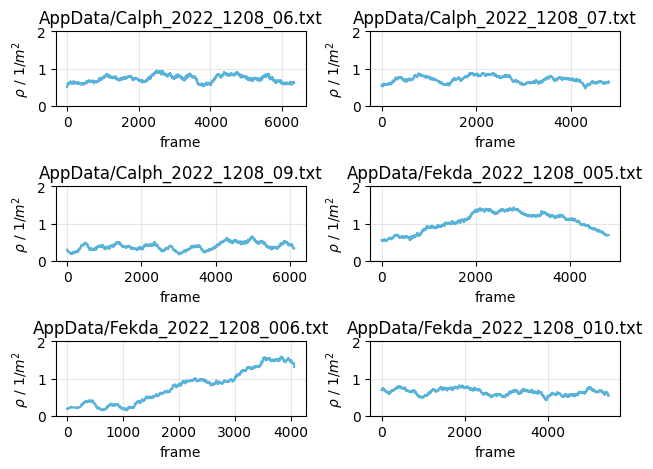

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2)
for ax, (filename, traj) in zip(axes.ravel(), trajectories.items()):
    pp.plot_density(density=density_voronoi[filename], title=filename, axes=ax)
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 2])

plt.tight_layout()

In [8]:
mean_speed = {}

for idx, (filename, traj) in enumerate(trajectories.items()):
    mean_speed[filename] = pp.compute_mean_speed_per_frame(
        traj_data=traj,
        measurement_area=walkable_area,
        individual_speed=individual_speed[filename],
    )

## Time series of mean speed


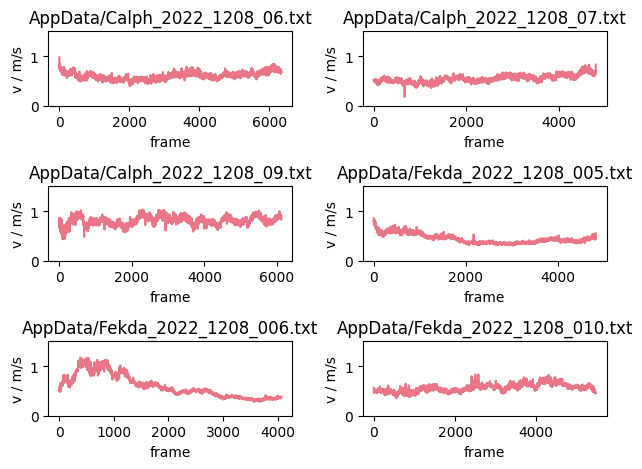

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2)
for ax, (filename, traj) in zip(axes.ravel(), trajectories.items()):
    pp.plot_speed(
        speed=mean_speed[filename], title=filename, color=pp.PEDPY_RED, axes=ax
    )
    ax.set_ylim([0, 1.5])
plt.tight_layout()

## Fundamental Diagrams

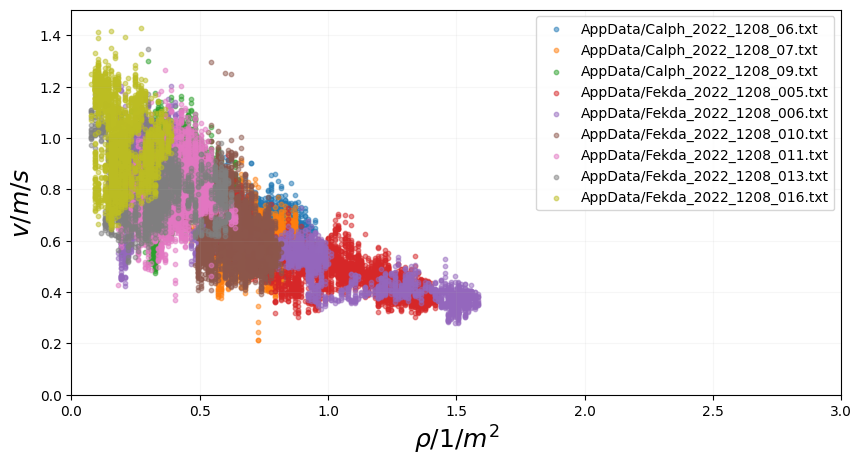

In [13]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
x = []
y = []
for filename, traj in trajectories.items():
    x += list(density_voronoi[filename][pp.column_identifier.DENSITY_COL])
    y += list(speed_voronoi[filename]["speed"])
    ax0.scatter(
        density_voronoi[filename][pp.column_identifier.DENSITY_COL],
        speed_voronoi[filename],
        label=filename,
        alpha=0.5,
        s=10,
    )
    ax0.set_xlabel(r"$\rho / 1/m^2$", fontsize=18)
    ax0.set_ylabel(r"$v/ m/s$", fontsize=18)
    ax0.grid(alpha=0.1)
    ax0.set_xlim([0, 3])
    ax0.set_ylim([0, 1.5])
    #ax0.set_title("all")
    ax0.legend(loc="best")
    ax0.set_aspect("equal", "box")    
#sns.kdeplot(x=x, y=y, fill=True, ax=ax1)
#ax1.set_xlabel(r"$rho\, /\, 1/m^2$")
#ax1.set_ylabel(r"$v\, /\, m/s$")
#ax1.grid(alpha=0.1)
#ax1.set_xlim([0, 1.5])
#ax1.set_ylim([0, 1.5])
#ax1.set_title("all - kdeplot")
#plt.show()

## Profiles

In [20]:
profile_data = {}
for idx, (filename, traj) in enumerate(trajectories.items()):
    print(filename)
    profile_data[filename] = individual_speed[filename].merge(voronoi_polygons[filename], on=[ID_COL, FRAME_COL])
    profile_data[filename] = profile_data[filename].merge(traj.data, on=[ID_COL, FRAME_COL])

AppData/Calph_2022_1208_06.txt
AppData/Calph_2022_1208_07.txt
AppData/Calph_2022_1208_09.txt
AppData/Fekda_2022_1208_005.txt
AppData/Fekda_2022_1208_006.txt
AppData/Fekda_2022_1208_010.txt
AppData/Fekda_2022_1208_011.txt
AppData/Fekda_2022_1208_013.txt
AppData/Fekda_2022_1208_016.txt


In [21]:
import pickle
profile_file = "AppData/profile_data.pkl"
with open(profile_file, "wb") as f:
    pickle.dump(profile_data, f)

In [22]:
grid_size = 0.4
grid_cells, _, _ = get_grid_cells(
    walkable_area=walkable_area, grid_size=grid_size
)
(grid_cell_intersection_area,resorted_profile_data,) = compute_grid_cell_polygon_intersection_area(data=profile_data, grid_cells=grid_cells)

TypeError: dict.copy() takes no keyword arguments

In [ ]:
voronoi_density_profile = pp.compute_density_profile(
    data=resorted_profile_data,
    walkable_area=walkable_area,
    grid_intersections_area=grid_cell_intersection_area,
    grid_size=grid_size,
    density_method=DensityMethod.VORONOI,
)

In [ ]:
voronoi_speed_profile = compute_speed_profile(
    data=resorted_profile_data,
    walkable_area=walkable_area,
    grid_intersections_area=grid_cell_intersection_area,
    grid_size=grid_size,
    speed_method=SpeedMethod.VORONOI,
)